In [62]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import ks_2samp
from xgboost import XGBRegressor
from causalml.inference.meta import XGBTRegressor

In [63]:
# Import Data
df = pd.read_csv('/Users/qianlou/Documents/GitHub/Customer-Personality-Analysis-2.0/Data/Preprocessed Data/Final Preprocessed Data.csv')


In [64]:
treatments = ['Income_Category_High', 'Is_Parent', 'Cmp_Attitude', 'Complain']
covariates_list = ['Income_Category_High', 'Income_Category_Low', 'Income_Category_Medium',
    'Complain', 'Is_Parent', 'Cmp_Attitude', 'Family_Size', 'Age',
    'Member_Year', 'Total_amount', 'Total_purchase',
    'NumWebVisitsMonth', 'NumDealsPurchases', 'Recency']
outcomes = ['Recency', 'Total_purchase', 'Total_amount']

In [65]:
# Causal inference pipeline function with drift detection
def causal_inference_pipeline_with_drift(df, X_cols, treatments):
    outcomes = ['Recency', 'Total_purchase', 'Total_amount']
    results = []
    drift_report = Report(metrics=[
        DatasetDriftMetric(),  # Entire dataset drift analysis
        DataDriftTable()  # Detailed table of feature-wise drift
    ])

    for outcome in outcomes:
        for treatment in treatments:
            # Prepare covariates
            covariates = [col for col in X_cols if col != treatment and col != outcome]
            if outcome == 'Total_purchase':
                covariates.remove('Total_amount')
            elif outcome == 'Total_amount':
                covariates.remove('Total_purchase')
            X = df[covariates]
            y = df[outcome]
            t = df[treatment]

            # Split data into training and testing sets
            X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
                X, y, t, test_size=0.2, random_state=42)

            # Run drift detection (Comparing training to test datasets)
            drift_report.run(reference_data=X_train, current_data=X_test)
            drift_report.save_html("drift_report_{}_{}.html".format(outcome, treatment))
            print(f'Drift report for outcome "{outcome}" and treatment "{treatment}" generated.')

            lowest_rmse = float('inf')
            best_model = None
            best_ate = None
            best_shap_values = None

            # Iterate over model types
            for model_type in [XGBRegressor, XGBTRegressor]:
                try:
                    # Model instantiation
                    if model_type == XGBRegressor:
                        model = model_type()
                        model.fit(X_train, y_train)
                        xgb_model = XGBRegressor()
                        xgb_model.fit(X_train, y_train)
                        explainer = shap.Explainer(xgb_model)
                        shap_values = explainer(X_test)
                    else:
                        model = model_type()
                        model.fit(X_train, t_train, y_train)

                    # Estimate ATE
                    ate_mean, ate_std = cross_validate_ate(model, X, t, y)

                    # Predictions for MSE calculation
                    y_pred = model.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                    if rmse < lowest_rmse:
                        lowest_rmse = rmse
                        best_model = model
                        best_ate = ate_mean
                        best_shap_values = shap_values

                except Exception as e:
                    print(f"Error training model for treatment {treatment} and outcome {outcome}:", e)

            if best_shap_values is not None:
                plt.title(f'SHAP Values for Treatment: {treatment}, Outcome: {outcome} ({best_model.__class__.__name__})')
                shap.summary_plot(best_shap_values, X_test, plot_type="bar")
                plt.show()

                plt.title(f'SHAP Values for Treatment: {treatment}, Outcome: {outcome} ({best_model.__class__.__name__})')
                shap.plots.beeswarm(best_shap_values, max_display=30)
                plt.show()

            results.append({
                'Outcome': outcome,
                'Treatment': treatment,
                'Model Type': best_model.__class__.__name__ if best_model else None,
                'ATE': best_ate,
                'RMSE': lowest_rmse
            })

    results_df = pd.DataFrame(results)

    return results_df
def cross_validate_ate(estimator, X, treatment, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    ate_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        treatment_train, treatment_test = treatment.iloc[train_index], treatment.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, treatment_train, y_train)
        ate_estimate = np.mean(estimator.predict(X_test))
        ate_scores.append(ate_estimate)

    return np.mean(ate_scores), np.std(ate_scores)


Drift report for outcome "Recency" and treatment "Income_Category_High" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



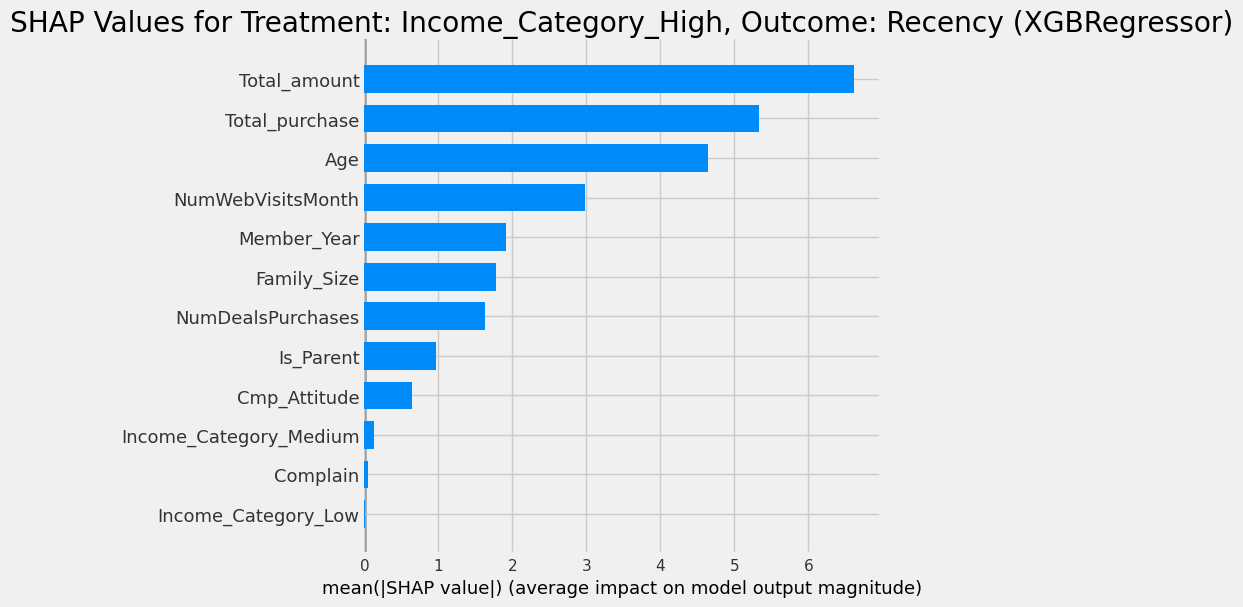

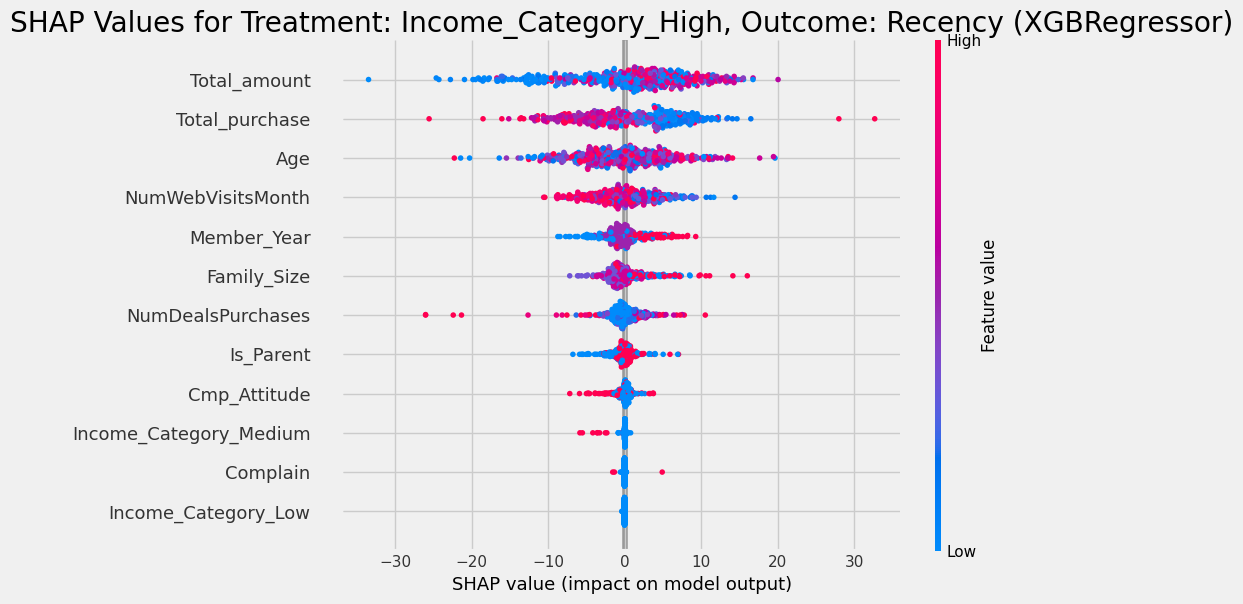

Drift report for outcome "Recency" and treatment "Is_Parent" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



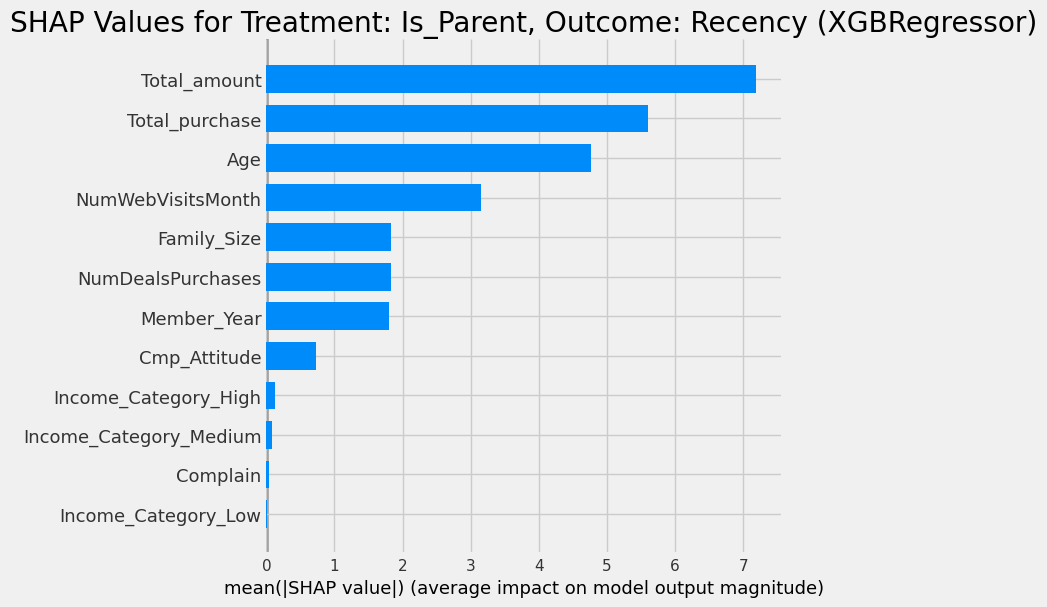

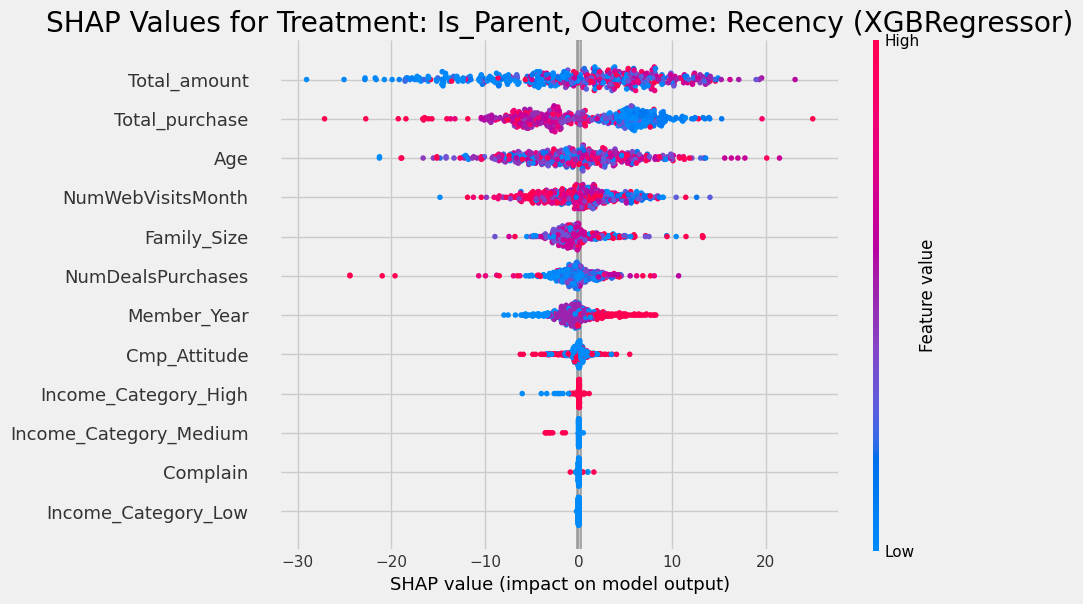

Drift report for outcome "Recency" and treatment "Cmp_Attitude" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



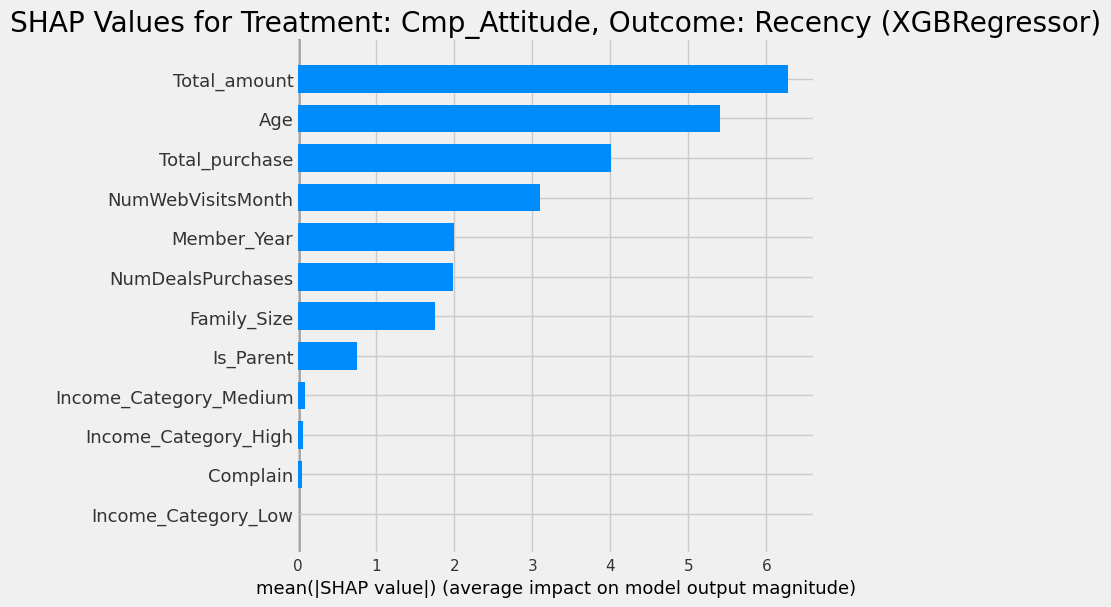

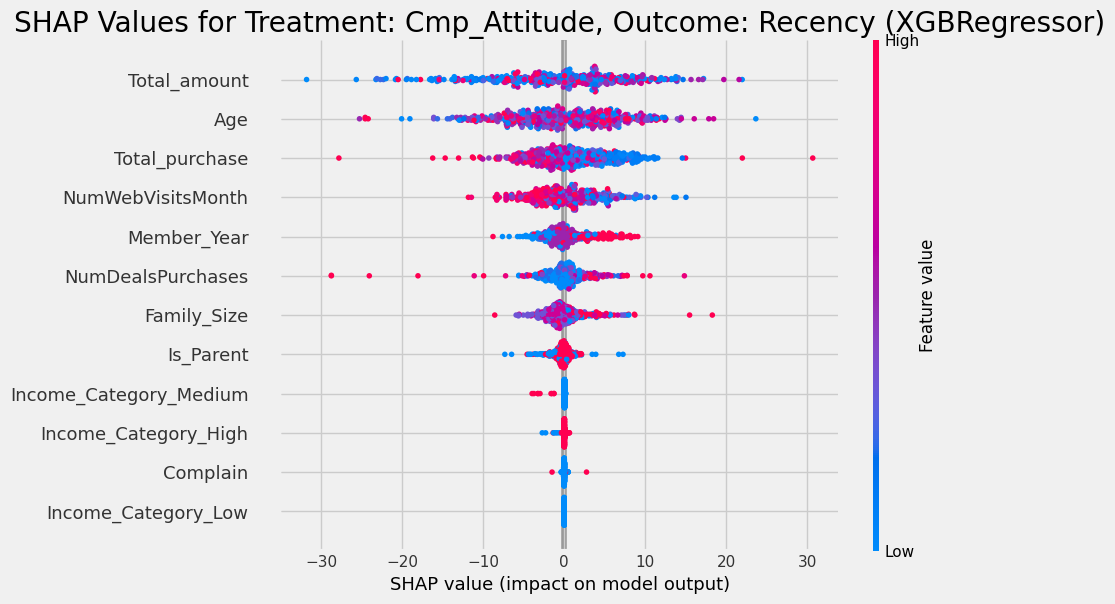

Drift report for outcome "Recency" and treatment "Complain" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:22] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



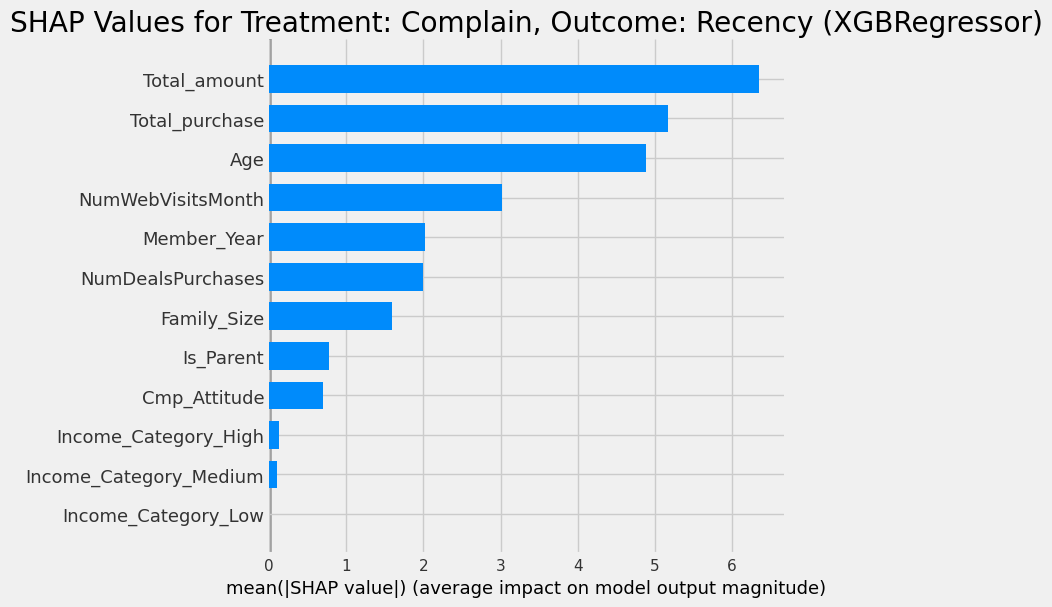

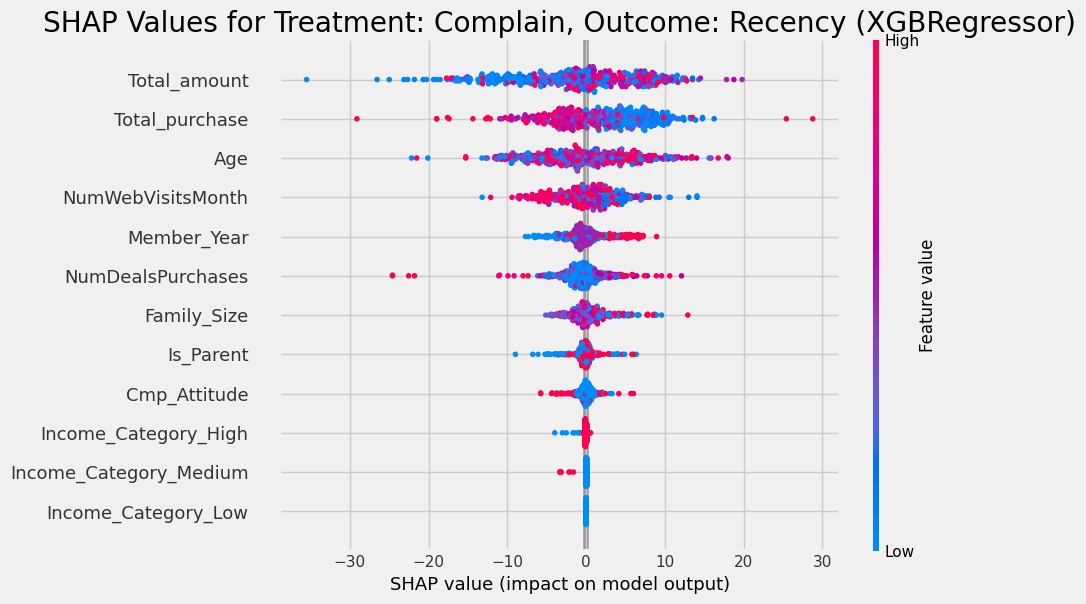

Drift report for outcome "Total_purchase" and treatment "Income_Category_High" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:27] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



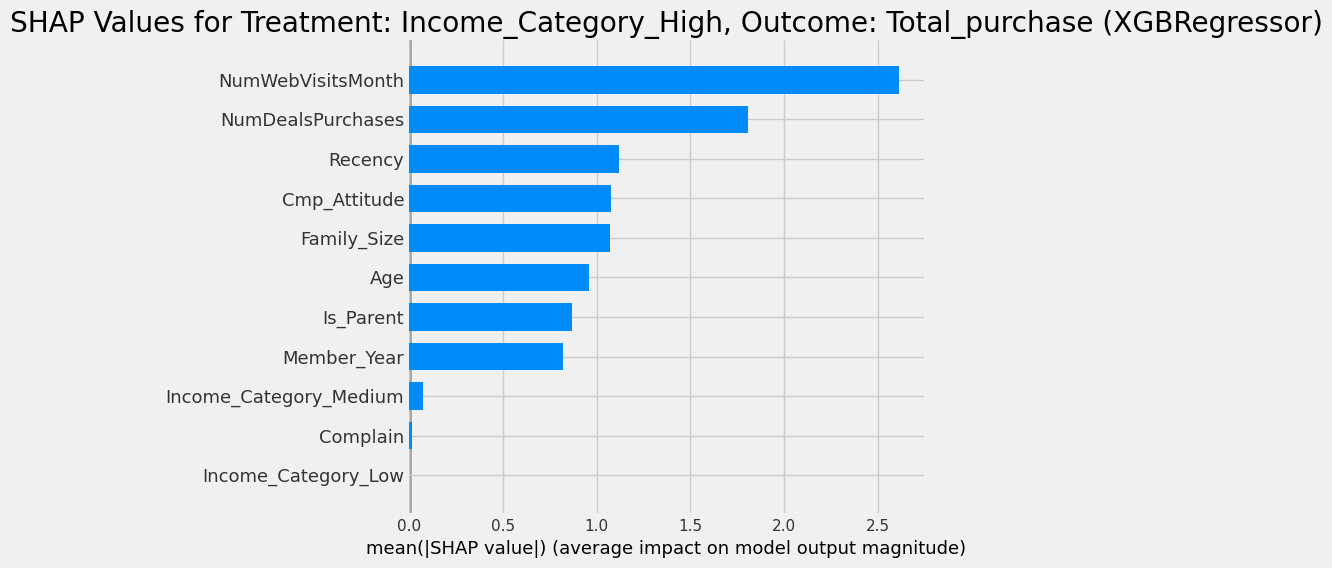

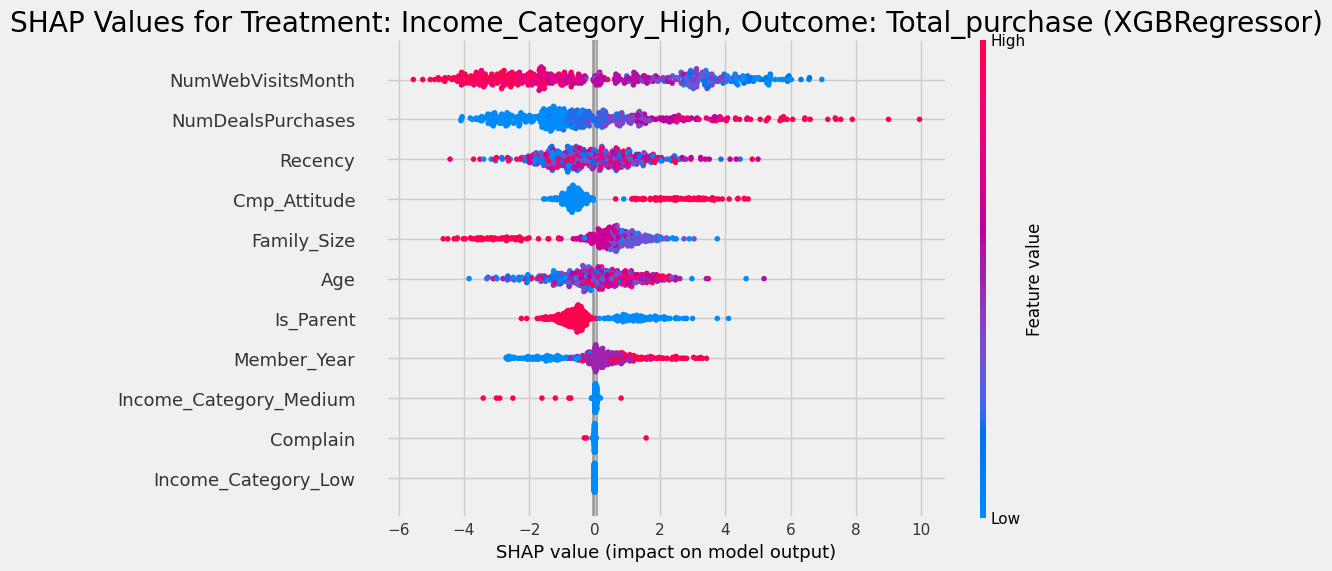

Drift report for outcome "Total_purchase" and treatment "Is_Parent" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:31] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



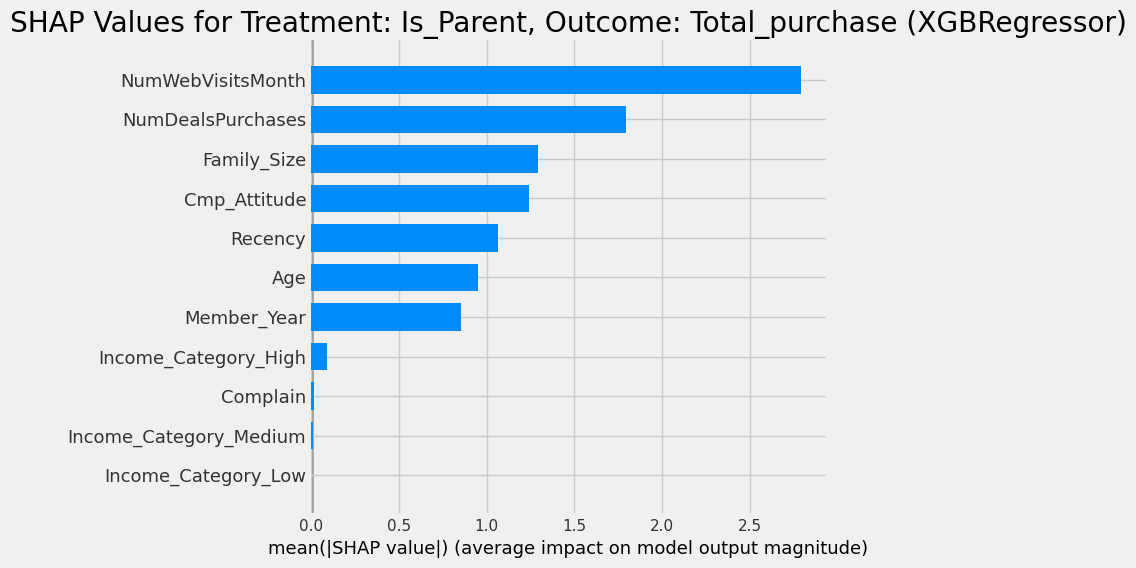

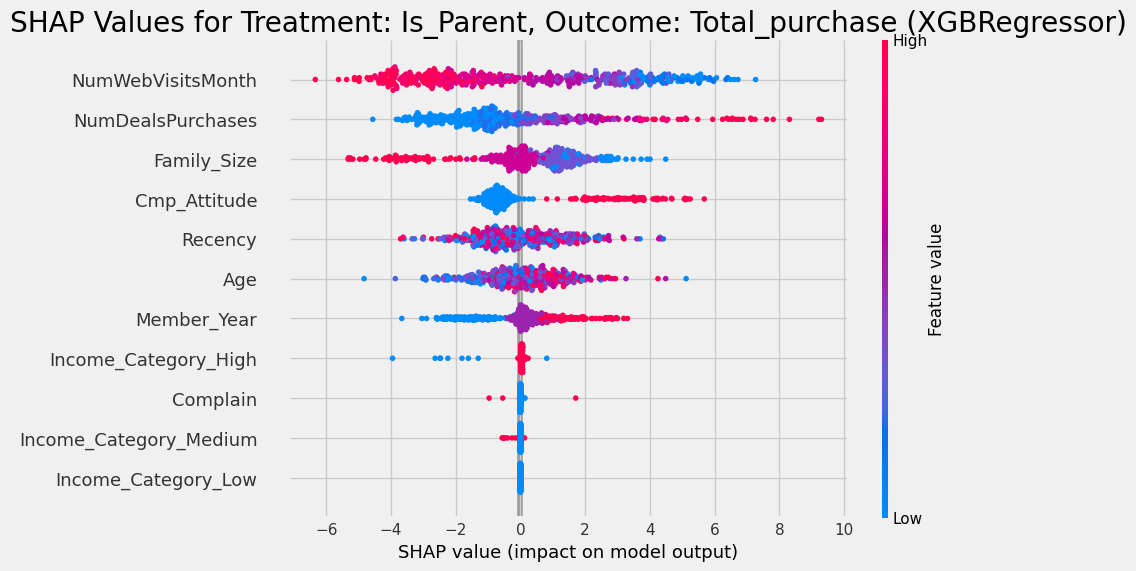

Drift report for outcome "Total_purchase" and treatment "Cmp_Attitude" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:38] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



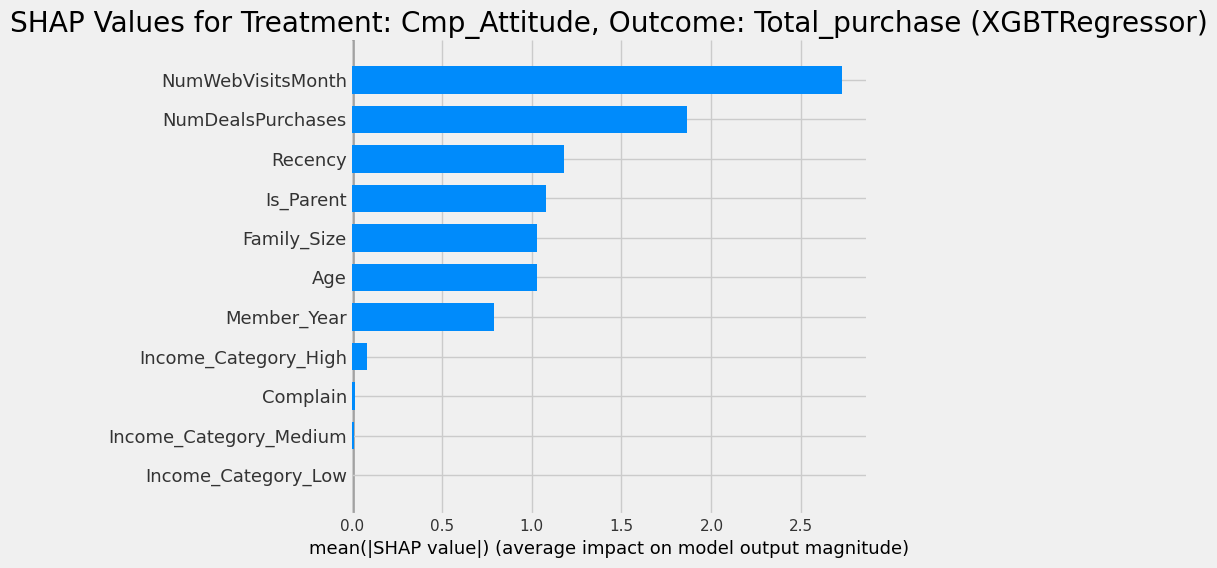

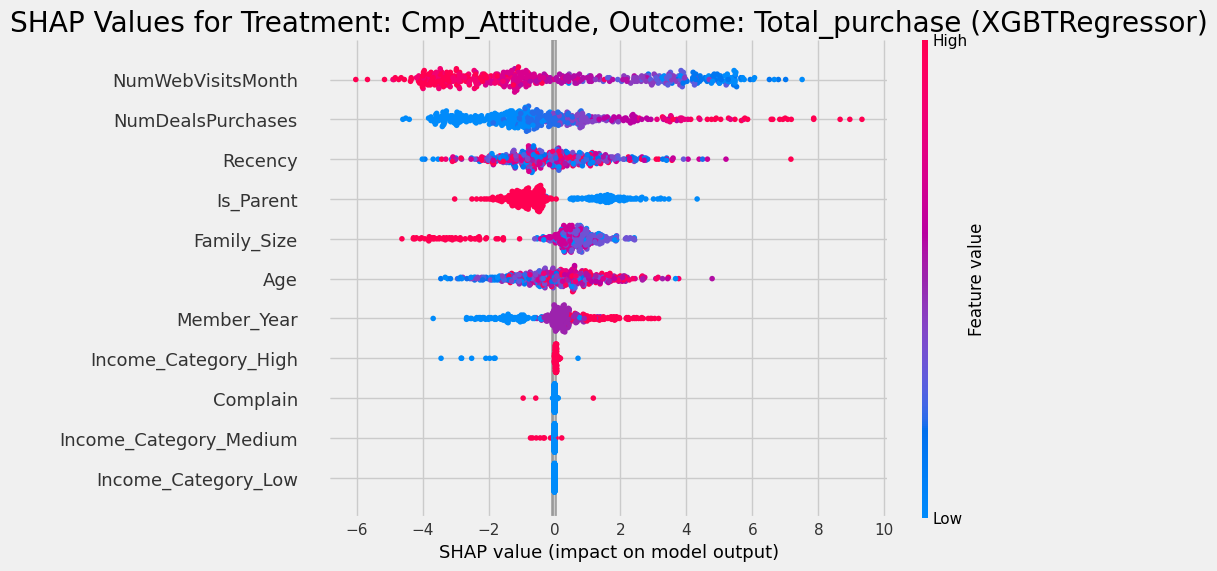

Drift report for outcome "Total_purchase" and treatment "Complain" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:45] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



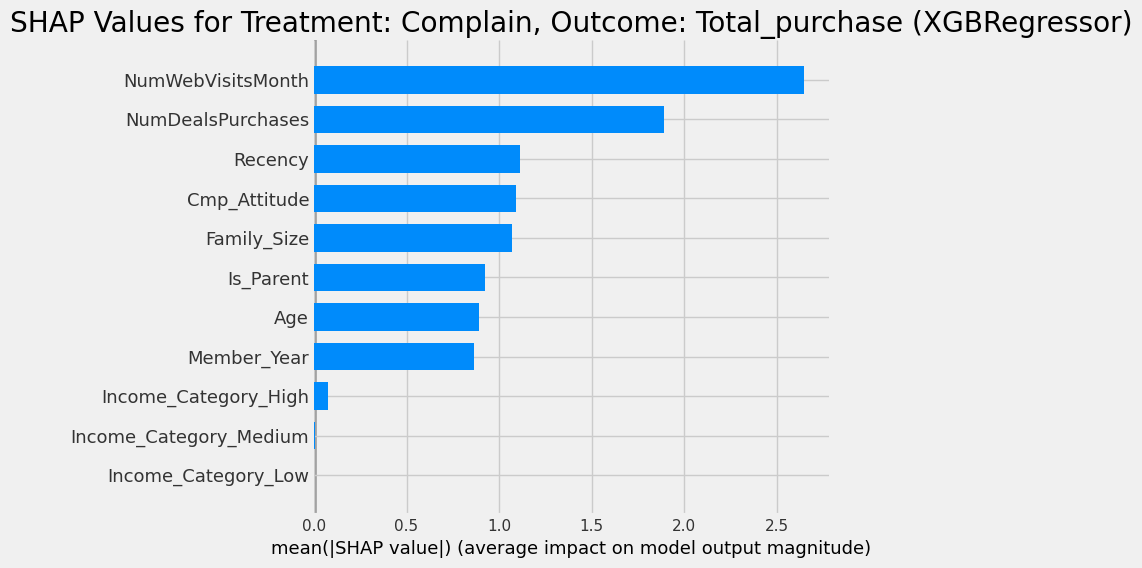

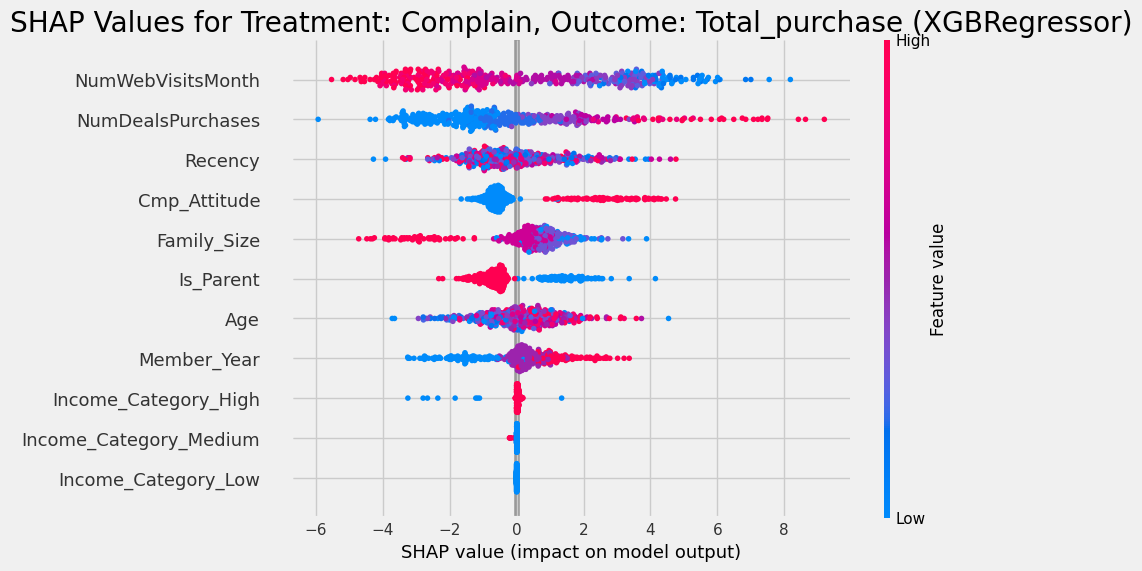

Drift report for outcome "Total_amount" and treatment "Income_Category_High" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:51] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



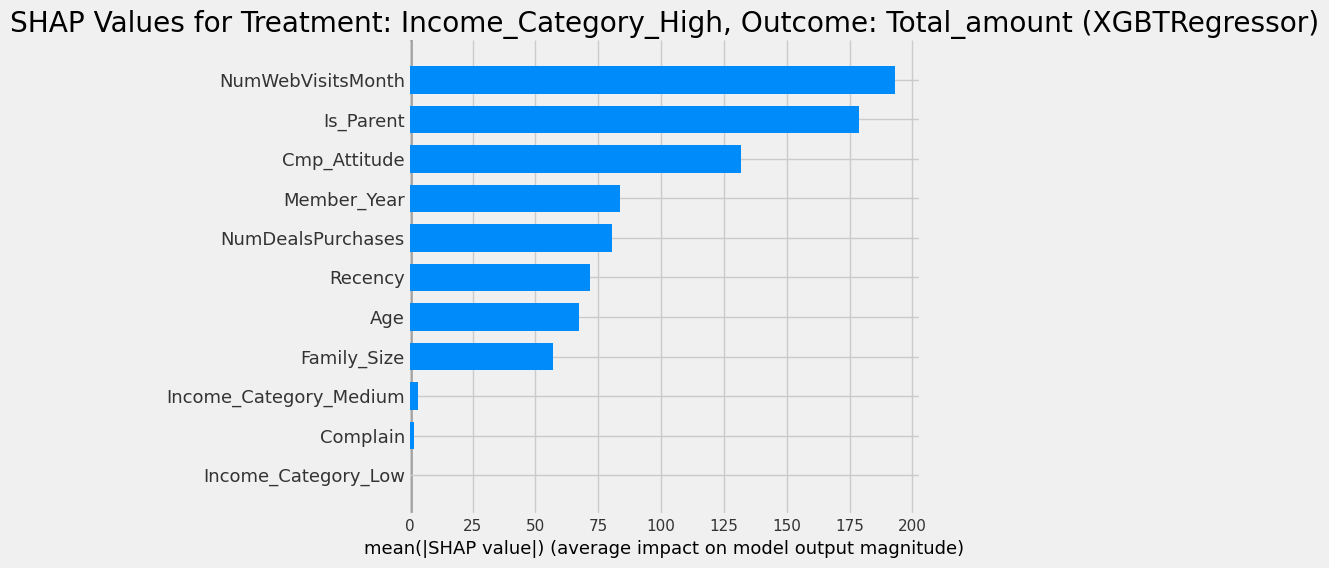

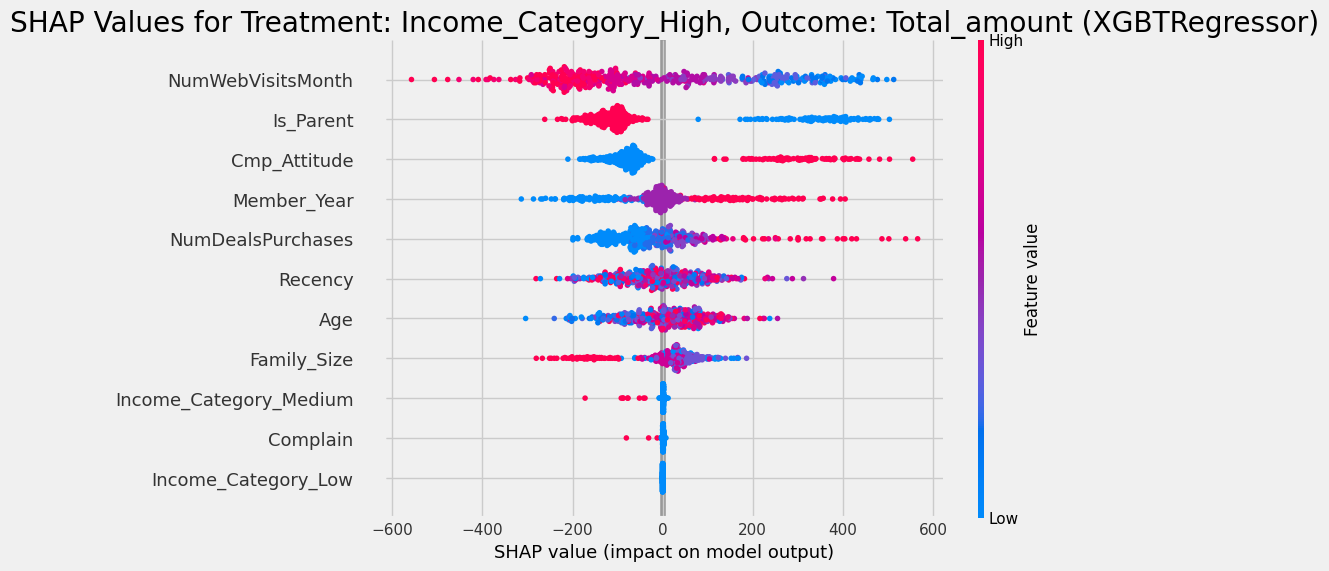

Drift report for outcome "Total_amount" and treatment "Is_Parent" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:44:57] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



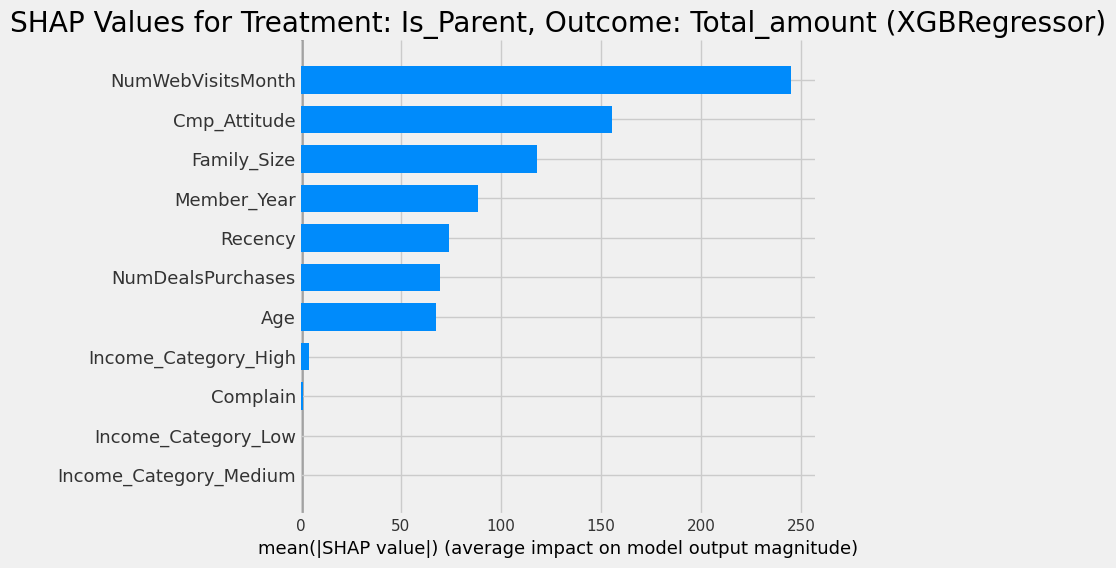

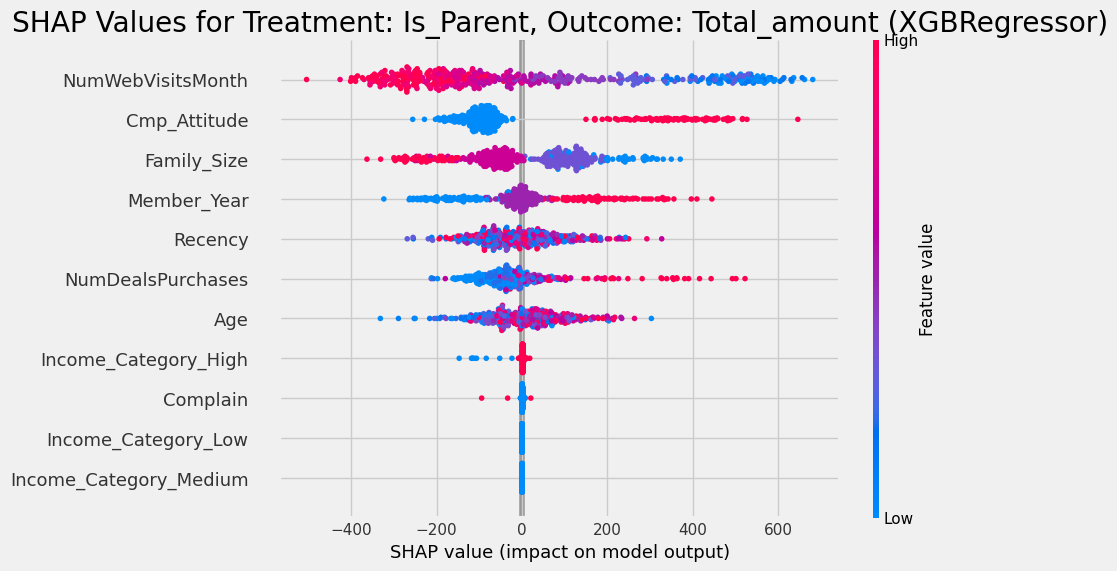

Drift report for outcome "Total_amount" and treatment "Cmp_Attitude" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



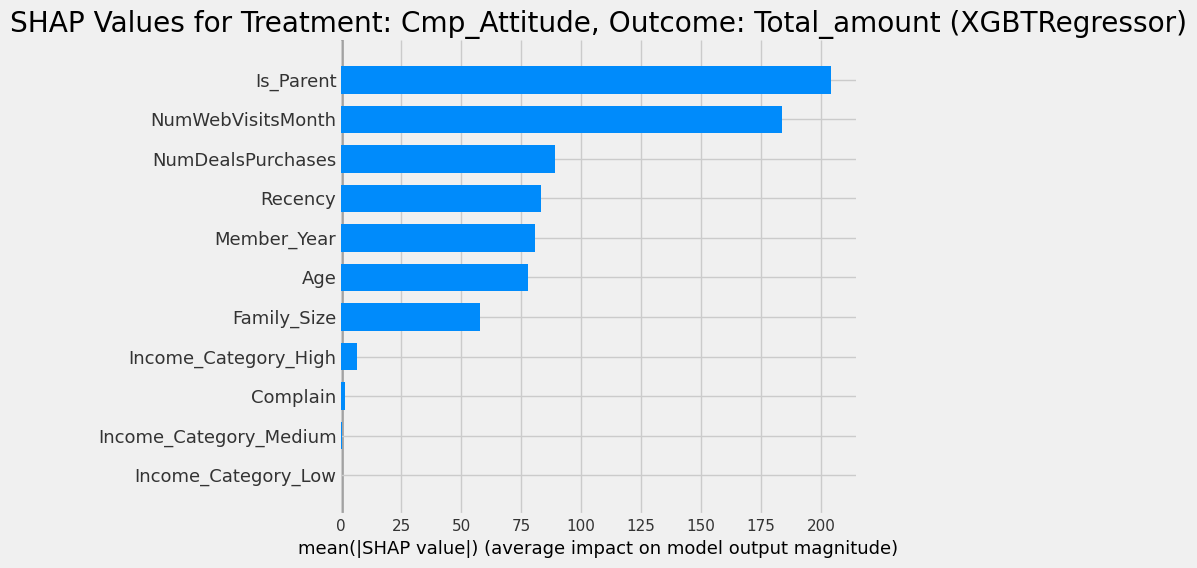

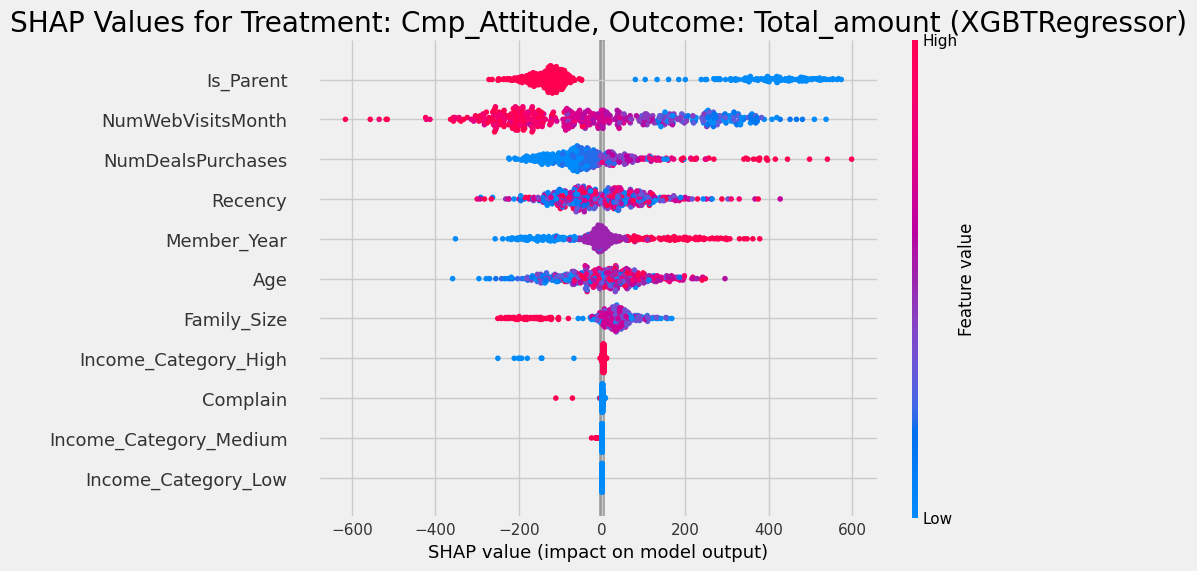

Drift report for outcome "Total_amount" and treatment "Complain" generated.


/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning:

[22:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/Users/qianlou/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning:

Pass `sample_weight` as keyword args.



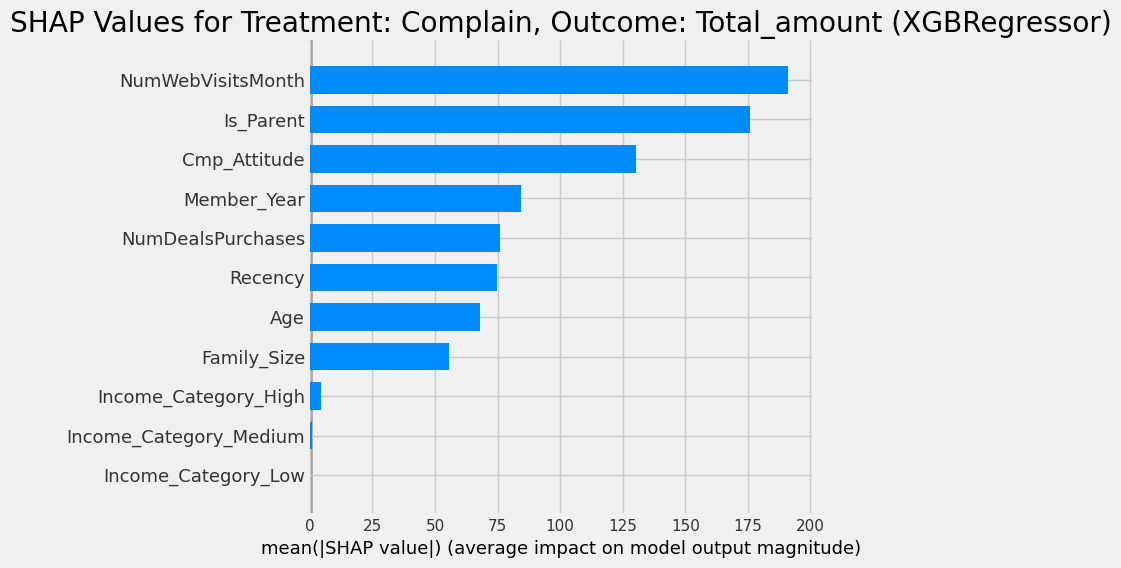

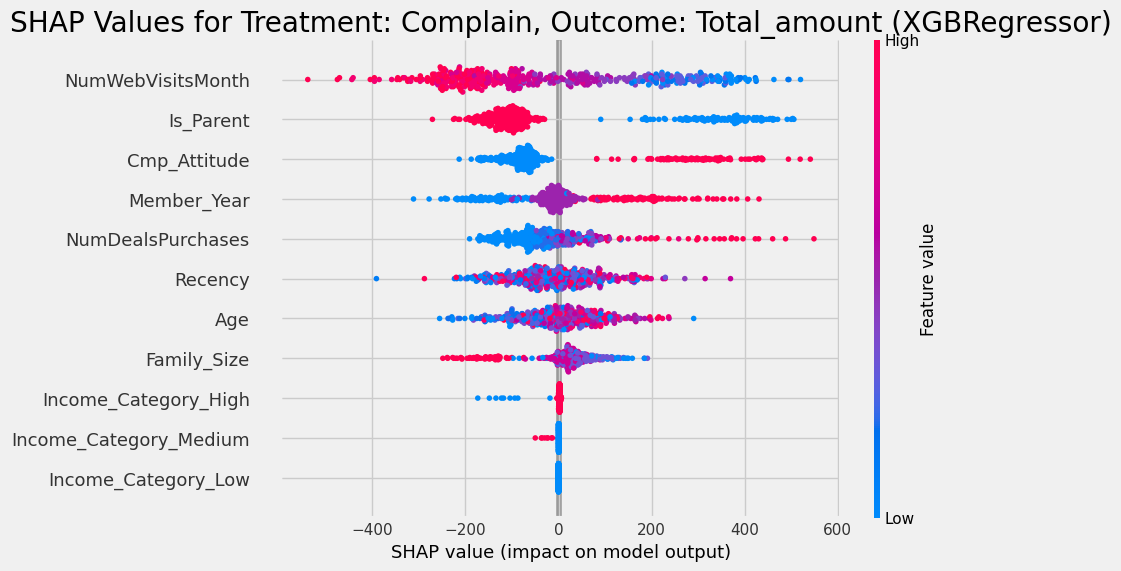

,Outcome,Treatment,Model Type,ATE,RMSE
0,Recency,Income_Category_High,XGBRegressor,0.984333,54.668270
1,Recency,Is_Parent,XGBRegressor,0.714969,54.865256
2,Recency,Cmp_Attitude,XGBRegressor,0.217046,55.342698
3,Recency,Complain,XGBRegressor,0.012355,55.493829
4,Total_purchase,Income_Category_High,XGBRegressor,0.984334,13.986251
5,Total_purchase,Is_Parent,XGBRegressor,0.714974,14.285645
6,Total_purchase,Cmp_Attitude,XGBTRegressor,3.572356,14.270610
7,Total_purchase,Complain,XGBRegressor,0.010959,14.830237
8,Total_amount,Income_Category_High,XGBTRegressor,346.352068,248.611976
9,Total_amount,Is_Parent,XGBRegressor,0.715721,857.820259


In [66]:
# Run causal inference pipeline with drift detection
results_df = causal_inference_pipeline_with_drift(df, covariates_list, treatments)
results_df